# Train a deep, recurrent convolutional SNN on the SHD dataset

In this notebook, we demonstrate the training of a 3-layer convolutional SNN with recurrent connections in each hidden layer on the [SHD dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/).

We will introduce the use of the `layer` module to initialize feed-forward and recurrent connections at the same time, from the same target parameter $\sigma_U$.

In [1]:
# First, imports
import os
import sys

sys.path.append("../../stork-1")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change the default color cycle
np.random.seed(20250129)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=np.random.permutation(cm.batlow(np.linspace(0, 1, 10)))
)

import stork
from stork.activations import CustomSpike
from stork.datasets import HDF5Dataset, DatasetView

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
)
from stork.layers import ConvLayer
from stork.plotting_new import plot_training

using my stork version - EI-assemblies


## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [2]:
datadir = "/tachyon/groups/gzenke/datasets/hdspikes"

#### Specifying dataset parameters

In [3]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
)

#### Load and split dataset into train / validation / test

In [4]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [5]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_hidden_layers = 3
nb_classes = 20
nb_filters = [16, 32, 64]  # Number of features per layer

kernel_size = [21, 7, 7]  # Convolutional operation parameters
stride = [10, 3, 3]
padding = [0, 0, 0]

recurrent_kwargs = {"kernel_size": 5, "stride": 1, "padding": 2}

# Neuron Parameters
# # # # # # # # # # #

neuron_group = LIFGroup
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

# Training parameters
# # # # # # # # # # #

batch_size = 400
device = torch.device("cuda:1")
dtype = torch.float
lr = 5e-3
nb_epochs = 200

#### SuperSpike and loss function setup

In [6]:
act_fn = CustomSpike
act_fn.escape_noise_type = "sigmoid"
act_fn.escape_noise_params = {"beta": beta}

act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}


loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

#### Optimizer setup

In [7]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=4)

#### Regularizer setup

In [8]:
# Define regularizer parameters (set regularizer strenght to 0 if you don't want to use them)
upperBoundL2Strength = 0.01
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)

# Define regularizer list
regs = []

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=-1
)
regs.append(regUB)

#### Initializer setup
We initialize in the fluctuation-driven regime with a target membrane potential standard deviation $\sigma_U=1.0$. Additionally, we set the proportion of membrane potential fluctuations driven by feed-forward inputs to $\alpha=0.9$.

In [9]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt, alpha=0.9
)

readout_initializer = DistInitializer(
    dist=torch.distributions.Normal(0, 1), scaling="1/sqrt(k)"
)

#### Assemble the model

In [10]:
model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)
# INPUT LAYER
# # # # # # # # # # # # # # #
input_shape = (1, nb_inputs)
input_group = model.add_group(InputGroup(input_shape))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYERS
# # # # # # # # # # # # # # #
neuron_kwargs = {"tau_mem": 20e-3, "tau_syn": 10e-3, "activation": act_fn}

for layer_idx in range(nb_hidden_layers):
    # Generate Layer name and config
    layer_name = str("ConvLayer") + " " + str(layer_idx)

    # Make layer
    layer = ConvLayer(
        name=layer_name,
        model=model,
        input_group=upstream_group,
        kernel_size=kernel_size[layer_idx],
        stride=stride[layer_idx],
        padding=padding[layer_idx],
        nb_filters=nb_filters[layer_idx],
        recurrent=True,
        neuron_class=neuron_group,
        neuron_kwargs=neuron_kwargs,
        recurrent_connection_kwargs=recurrent_kwargs,
        regs=regs,
    )

    # Initialize Parameters
    initializer.initialize(layer)

    # Set output as input to next layer
    upstream_group = layer.output_group

# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(
    ReadoutGroup(
        nb_classes,
        tau_mem=tau_readout,
        tau_syn=neuron_kwargs["tau_syn"],
        initial_state=-1e-3,
    )
)

readout_connection = model.add_connection(
    Connection(upstream_group, readout_group, flatten_input=True)
)

# Initialize readout connection
readout_initializer.initialize(readout_connection)

#### Add monitors for spikes and membrane potential

In [11]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

#### Configure model for training

In [12]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

## Monitoring activity before training

In [13]:
# Monitors spike counts before training
results = {}

res = model.monitor(test_dataset)
for k, v in res.items():
    results["Pre test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(train_dataset)
for k, v in res.items():
    results["Pre train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

SpikeCountMonitor-ConvLayer 0 torch.Size([2264, 16, 68])
SpikeCountMonitor-ConvLayer 1 torch.Size([2264, 32, 21])
SpikeCountMonitor-ConvLayer 2 torch.Size([2264, 64, 5])
StateMonitor-ConvLayer 0 torch.Size([2264, 349, 16, 68])
StateMonitor-ConvLayer 1 torch.Size([2264, 349, 32, 21])
StateMonitor-ConvLayer 2 torch.Size([2264, 349, 64, 5])
SpikeCountMonitor-ConvLayer 0 torch.Size([7340, 16, 68])
SpikeCountMonitor-ConvLayer 1 torch.Size([7340, 32, 21])
SpikeCountMonitor-ConvLayer 2 torch.Size([7340, 64, 5])
StateMonitor-ConvLayer 0 torch.Size([7340, 349, 16, 68])
StateMonitor-ConvLayer 1 torch.Size([7340, 349, 32, 21])
StateMonitor-ConvLayer 2 torch.Size([7340, 349, 64, 5])


plotting


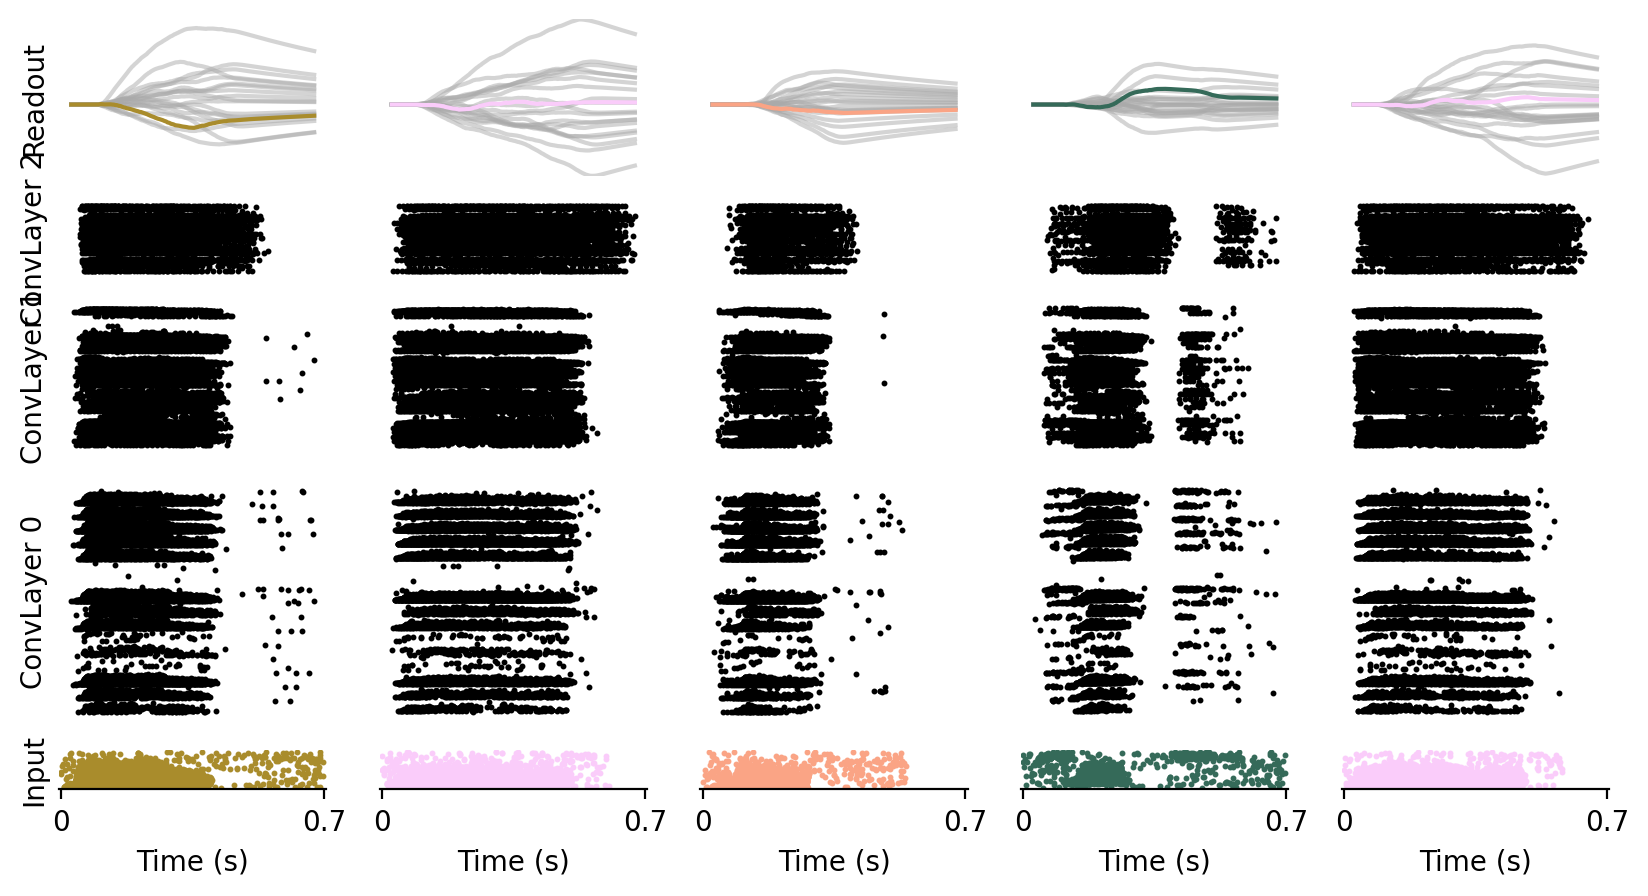

In [14]:
# create nice classification color palette for plotting
colors = cm.batlow(np.linspace(0, 1, nb_classes))

pl = stork.plotting_new.ActivityPlotter(
    model=model,
    data=test_dataset,
    nb_samples=5,
    figsize=(10, 5),
    dpi=200,
    plot_label=True,
    label_color="navy",
    batch_size=batch_size,
    pal=colors,
    scale_input=0.25
)
fig = pl.plot_activity()

## Training

takes around 85 minutes using a powerful GPU

In [15]:
history = model.fit_validate(train_dataset, valid_dataset, nb_epochs=nb_epochs, verbose=True)

for k, v in history.items():
    if k in results:
        results[k] = np.concatenate([results[k], v], axis=0)
    else:
        results[k] = np.array(v)

scores = model.evaluate(test_dataset).tolist()
print("Scores", scores)
test_dict = model.get_metrics_dict(scores, prefix="test_")

for k, v in test_dict.items():
    if k in results:
        results[k] = np.concatenate([results[k], [v]], axis=0)
    else:
        results[k] = np.array([v])

00  loss = 2.941e+00, reg_loss = 7.674e-01, acc = 12.5% -- val_loss = 2.711e+00, val_reg_loss = 1.823e-01, val_acc = 17.8% t_iter=32.23
01  loss = 2.673e+00, reg_loss = 1.113e-01, acc = 22.0% -- val_loss = 2.348e+00, val_reg_loss = 4.656e-02, val_acc = 38.1% t_iter=32.06
02  loss = 2.298e+00, reg_loss = 6.321e-02, acc = 30.9% -- val_loss = 2.100e+00, val_reg_loss = 3.646e-02, val_acc = 37.0% t_iter=31.55
03  loss = 1.981e+00, reg_loss = 6.761e-02, acc = 37.4% -- val_loss = 2.084e+00, val_reg_loss = 1.085e-01, val_acc = 36.4% t_iter=27.63
04  loss = 1.764e+00, reg_loss = 7.436e-02, acc = 44.2% -- val_loss = 1.615e+00, val_reg_loss = 6.895e-02, val_acc = 47.9% t_iter=24.82
05  loss = 1.551e+00, reg_loss = 7.972e-02, acc = 50.5% -- val_loss = 1.471e+00, val_reg_loss = 9.521e-02, val_acc = 55.8% t_iter=24.90
06  loss = 1.355e+00, reg_loss = 8.461e-02, acc = 57.5% -- val_loss = 1.372e+00, val_reg_loss = 9.054e-02, val_acc = 60.2% t_iter=25.12
07  loss = 1.207e+00, reg_loss = 8.492e-02, acc 

plotting


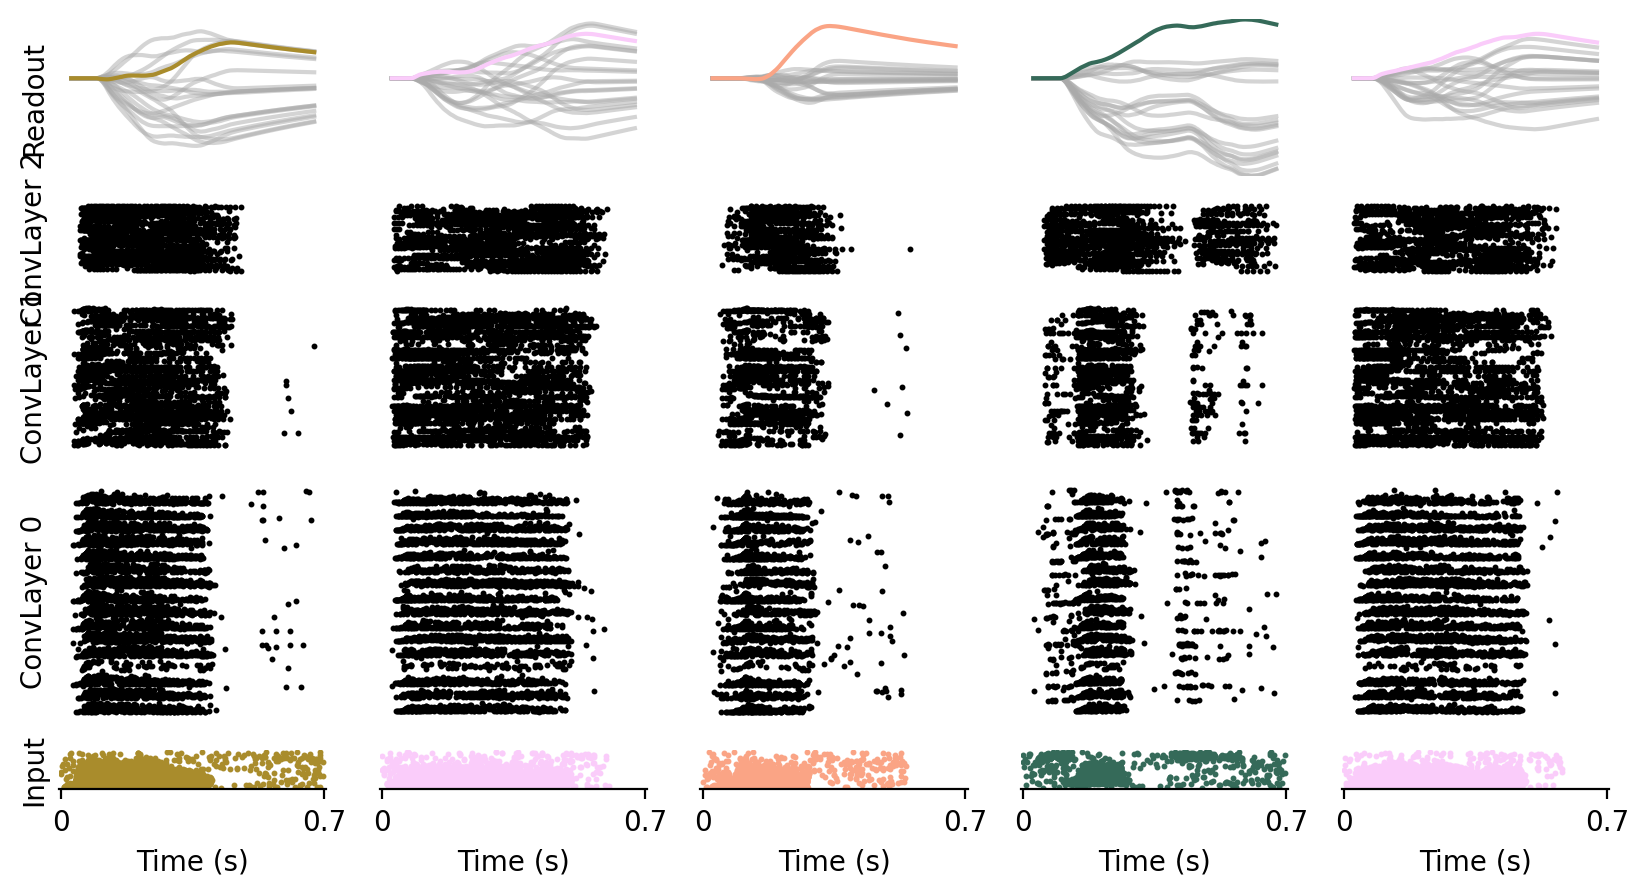

In [16]:
fig = pl.plot_activity()

In [17]:
res = model.monitor(test_dataset)
for k, v in res.items():
    results["Post test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(train_dataset)
for k, v in res.items():
    results["Post train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

SpikeCountMonitor-ConvLayer 0 torch.Size([2264, 16, 68])
SpikeCountMonitor-ConvLayer 1 torch.Size([2264, 32, 21])
SpikeCountMonitor-ConvLayer 2 torch.Size([2264, 64, 5])
StateMonitor-ConvLayer 0 torch.Size([2264, 349, 16, 68])
StateMonitor-ConvLayer 1 torch.Size([2264, 349, 32, 21])
StateMonitor-ConvLayer 2 torch.Size([2264, 349, 64, 5])
SpikeCountMonitor-ConvLayer 0 torch.Size([7340, 16, 68])
SpikeCountMonitor-ConvLayer 1 torch.Size([7340, 32, 21])
SpikeCountMonitor-ConvLayer 2 torch.Size([7340, 64, 5])
StateMonitor-ConvLayer 0 torch.Size([7340, 349, 16, 68])
StateMonitor-ConvLayer 1 torch.Size([7340, 349, 32, 21])
StateMonitor-ConvLayer 2 torch.Size([7340, 349, 64, 5])


## Test

In [18]:
scores = model.evaluate(test_dataset).tolist()

print("Test acc:", np.round(results["test_acc"][-1]*100, 2), "%")

Test acc: 81.62 %


#### Visualize performance

dict_keys(['Pre test SpikeCountMonitor-ConvLayer 0', 'Pre test SpikeCountMonitor-ConvLayer 1', 'Pre test SpikeCountMonitor-ConvLayer 2', 'Pre test StateMonitor-ConvLayer 0', 'Pre test StateMonitor-ConvLayer 1', 'Pre test StateMonitor-ConvLayer 2', 'Pre train SpikeCountMonitor-ConvLayer 0', 'Pre train SpikeCountMonitor-ConvLayer 1', 'Pre train SpikeCountMonitor-ConvLayer 2', 'Pre train StateMonitor-ConvLayer 0', 'Pre train StateMonitor-ConvLayer 1', 'Pre train StateMonitor-ConvLayer 2', 'loss', 'reg_loss', 'acc', 'val_loss', 'val_reg_loss', 'val_acc', 'test_loss', 'test_reg_loss', 'test_acc', 'Post test SpikeCountMonitor-ConvLayer 0', 'Post test SpikeCountMonitor-ConvLayer 1', 'Post test SpikeCountMonitor-ConvLayer 2', 'Post test StateMonitor-ConvLayer 0', 'Post test StateMonitor-ConvLayer 1', 'Post test StateMonitor-ConvLayer 2', 'Post train SpikeCountMonitor-ConvLayer 0', 'Post train SpikeCountMonitor-ConvLayer 1', 'Post train SpikeCountMonitor-ConvLayer 2', 'Post train StateMonitor-C

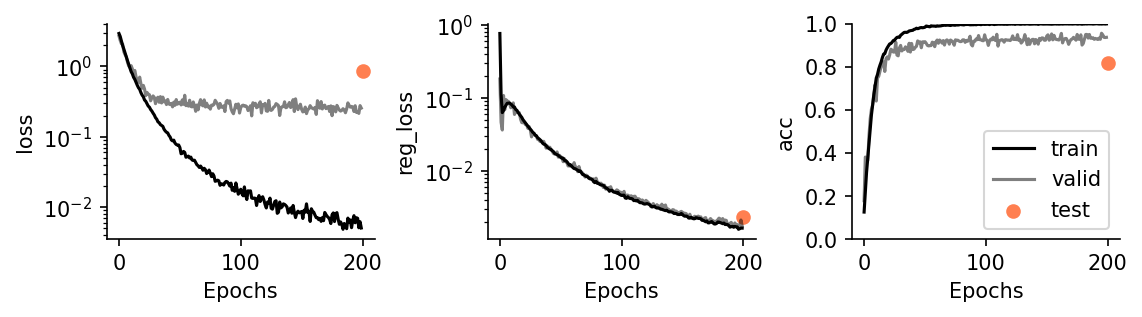

In [19]:
print(results.keys())
names = [k for k in results.keys() if not ("val" in k or "test" in k or "Monitor" in k)]
print(names)

fig = plot_training(
    results,
    nb_epochs=nb_epochs,
    epoch_chunks=1,  # cfg.training.epoch_chunks,
    names=names,
)